In [37]:
# === Combine BOTH sheets -> clean -> save CSV ===
import pandas as pd, numpy as np, re
from pathlib import Path

# paths (adjust if needed)
FILE = Path("../data/Flight_Data.xlsx")
OUT_CSV = FILE.parent / "flight_data_clean9amto12pm.csv"

# time extraction helpers
clock12 = re.compile(r"(\d{1,2}:\d{2}\s*[AP]M)", flags=re.I)
clock24 = re.compile(r"(\d{1,2}:\d{2})(?::\d{2})?")

def extract_clock_str(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    m = clock12.search(s)
    if m: return pd.to_datetime(m.group(1)).strftime("%H:%M:%S")
    m = clock24.search(s)
    if m: return pd.to_datetime(m.group(1)).strftime("%H:%M:%S")
    # already datetime?
    try:
        return pd.to_datetime(s, errors="raise").strftime("%H:%M:%S")
    except Exception:
        return np.nan

def force_date_with_time(date_s, time_s):
    dpart = pd.to_datetime(date_s, errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")
    tpart = time_s.apply(extract_clock_str)
    combo = dpart + " " + tpart.fillna("00:00:00")
    out = pd.to_datetime(combo, errors="coerce")
    out[tpart.isna()] = pd.NaT
    return out

# 1) Read both sheets
xls = pd.ExcelFile(FILE)
want = ["9AM - 12PM"]
missing = [s for s in want if s not in xls.sheet_names]
if missing:
    raise RuntimeError(f"Sheet(s) missing in Excel: {missing}. Found: {xls.sheet_names}")

dfs = []
for sh in want:
    df = pd.read_excel(FILE, sheet_name=sh)
    df["__sheet__"] = sh
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)

# 2) Basic clean
raw = raw.applymap(lambda x: str(x).replace("\xa0", "").strip() if isinstance(x, str) else x)

# 3) Forward-fill Date and Flight Number BEFORE parsing
#    (many rows have blank cells under the same header group)
if "Date" not in raw.columns and "Unnamed: 2" in raw.columns:
    raw = raw.rename(columns={"Unnamed: 2": "Date"})

for col in ["Date", "Flight Number"]:
    if col in raw.columns:
        raw[col] = raw[col].replace({"": np.nan, "nan": np.nan}).ffill()

# 4) Parse Date
raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce", dayfirst=True)

# 5) Clean ATA like "Landed 11:02 AM"
if "ATA" in raw.columns:
    raw["ATA"] = raw["ATA"].astype(str).str.replace(r"(?i)^\s*landed\s*", "", regex=True).replace({"": np.nan})

# 6) Build proper timestamps for STD/ATD/STA/ATA from Date + time text
for col in ["STD","ATD","STA","ATA"]:
    if col in raw.columns:
        raw[col] = force_date_with_time(raw["Date"], raw[col])

# 7) Compute delays
raw["dep_delay_min"] = (raw["ATD"] - raw["STD"]).dt.total_seconds() / 60
raw["arr_delay_min"] = (raw["ATA"] - raw["STA"]).dt.total_seconds() / 60

# 8) Keep rows that have a forward-filled Date string (even if some times are NaT)
raw = raw[raw["Date"].notna()].copy()

# 9) Save
raw.to_csv(OUT_CSV, index=False)
print(f"✅ Saved combined clean CSV with {len(raw)} rows → {OUT_CSV}")

# sanity checks
print("Rows per sheet:")
print(raw["__sheet__"].value_counts(dropna=False))
print("\nNon-null delays:",
      "dep:", int(raw["dep_delay_min"].notna().sum()),
      "| arr:", int(raw["arr_delay_min"].notna().sum()))


C:\Users\jaanh\AppData\Local\Temp\ipykernel_24664\3953105018.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(lambda x: str(x).replace("\xa0", "").strip() if isinstance(x, str) else x)


✅ Saved combined clean CSV with 515 rows → ..\data\flight_data_clean9amto12pm.csv
Rows per sheet:
__sheet__
9AM - 12PM    515
Name: count, dtype: int64

Non-null delays: dep: 394 | arr: 397


In [38]:
# === Combine BOTH sheets -> clean -> save CSV ===
import pandas as pd, numpy as np, re
from pathlib import Path

# paths (adjust if needed)
FILE = Path("../data/Flight_Data.xlsx")
OUT_CSV = FILE.parent / "flight_data_clean_6amto9am.csv"

# time extraction helpers
clock12 = re.compile(r"(\d{1,2}:\d{2}\s*[AP]M)", flags=re.I)
clock24 = re.compile(r"(\d{1,2}:\d{2})(?::\d{2})?")

def extract_clock_str(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    m = clock12.search(s)
    if m: return pd.to_datetime(m.group(1)).strftime("%H:%M:%S")
    m = clock24.search(s)
    if m: return pd.to_datetime(m.group(1)).strftime("%H:%M:%S")
    # already datetime?
    try:
        return pd.to_datetime(s, errors="raise").strftime("%H:%M:%S")
    except Exception:
        return np.nan

def force_date_with_time(date_s, time_s):
    dpart = pd.to_datetime(date_s, errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")
    tpart = time_s.apply(extract_clock_str)
    combo = dpart + " " + tpart.fillna("00:00:00")
    out = pd.to_datetime(combo, errors="coerce")
    out[tpart.isna()] = pd.NaT
    return out

# 1) Read both sheets
xls = pd.ExcelFile(FILE)
want = ["6AM - 9AM"]
missing = [s for s in want if s not in xls.sheet_names]
if missing:
    raise RuntimeError(f"Sheet(s) missing in Excel: {missing}. Found: {xls.sheet_names}")

dfs = []
for sh in want:
    df = pd.read_excel(FILE, sheet_name=sh)
    df["__sheet__"] = sh
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)

# 2) Basic clean
raw = raw.applymap(lambda x: str(x).replace("\xa0", "").strip() if isinstance(x, str) else x)

# 3) Forward-fill Date and Flight Number BEFORE parsing
#    (many rows have blank cells under the same header group)
if "Date" not in raw.columns and "Unnamed: 2" in raw.columns:
    raw = raw.rename(columns={"Unnamed: 2": "Date"})

for col in ["Date", "Flight Number"]:
    if col in raw.columns:
        raw[col] = raw[col].replace({"": np.nan, "nan": np.nan}).ffill()

# 4) Parse Date
raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce", dayfirst=True)

# 5) Clean ATA like "Landed 11:02 AM"
if "ATA" in raw.columns:
    raw["ATA"] = raw["ATA"].astype(str).str.replace(r"(?i)^\s*landed\s*", "", regex=True).replace({"": np.nan})

# 6) Build proper timestamps for STD/ATD/STA/ATA from Date + time text
for col in ["STD","ATD","STA","ATA"]:
    if col in raw.columns:
        raw[col] = force_date_with_time(raw["Date"], raw[col])

# 7) Compute delays
raw["dep_delay_min"] = (raw["ATD"] - raw["STD"]).dt.total_seconds() / 60
raw["arr_delay_min"] = (raw["ATA"] - raw["STA"]).dt.total_seconds() / 60

# 8) Keep rows that have a forward-filled Date string (even if some times are NaT)
raw = raw[raw["Date"].notna()].copy()

# 9) Save
raw.to_csv(OUT_CSV, index=False)
print(f"✅ Saved combined clean CSV with {len(raw)} rows → {OUT_CSV}")

# sanity checks
print("Rows per sheet:")
print(raw["__sheet__"].value_counts(dropna=False))
print("\nNon-null delays:",
      "dep:", int(raw["dep_delay_min"].notna().sum()),
      "| arr:", int(raw["arr_delay_min"].notna().sum()))


C:\Users\jaanh\AppData\Local\Temp\ipykernel_24664\1261736433.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw = raw.applymap(lambda x: str(x).replace("\xa0", "").strip() if isinstance(x, str) else x)


✅ Saved combined clean CSV with 499 rows → ..\data\flight_data_clean_6amto9am.csv
Rows per sheet:
__sheet__
6AM - 9AM    499
Name: count, dtype: int64

Non-null delays: dep: 385 | arr: 384


In [40]:
import pandas as pd

f1 = r"C:\college\honeywell\data\flight_data_clean_6amto9am.csv"
f2 = r"C:\college\honeywell\data\flight_data_clean9amto12pm.csv"
out = r"C:\college\honeywell\data\flight_data_clean.csv"

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)

df = pd.concat([df1, df2], ignore_index=True)

# --- Relaxed keep rule ---
has_fn = df["Flight Number"].notna()
has_time = df[["STD","ATD","STA","ATA"]].notna().any(axis=1)
has_from = df["From"].notna()

df = df[has_fn & (has_time | has_from)].copy()

# --- Sort & serial numbers ---
sort_cols = [c for c in ["Date","STD","ATD","Flight Number"] if c in df.columns]
df = df.sort_values(sort_cols).reset_index(drop=True)

df["S.No"] = range(1, len(df)+1)
df = df[["S.No"] + [c for c in df.columns if c != "S.No"]]

df.to_csv(out, index=False)
print(f"✅ Combined and saved → {out}")
print("Final row count:", len(df))
print(df['__sheet__'].value_counts())


✅ Combined and saved → C:\college\honeywell\data\flight_data_clean.csv
Final row count: 785
__sheet__
9AM - 12PM    400
6AM - 9AM     385
Name: count, dtype: int64


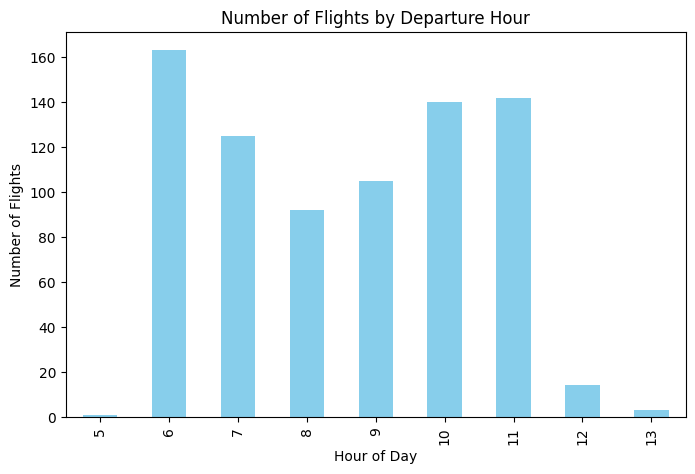

In [46]:
import matplotlib.pyplot as plt

df["dep_hour"] = df["STD"].dt.hour

plt.figure(figsize=(8,5))
df["dep_hour"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Number of Flights by Departure Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Flights")
plt.show()


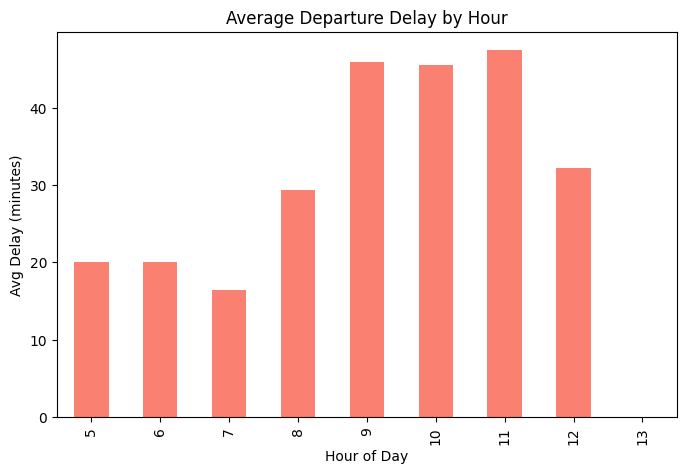

In [47]:
avg_dep_delay = df.groupby("dep_hour")["dep_delay_min"].mean()

plt.figure(figsize=(8,5))
avg_dep_delay.plot(kind="bar", color="salmon")
plt.title("Average Departure Delay by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Delay (minutes)")
plt.show()


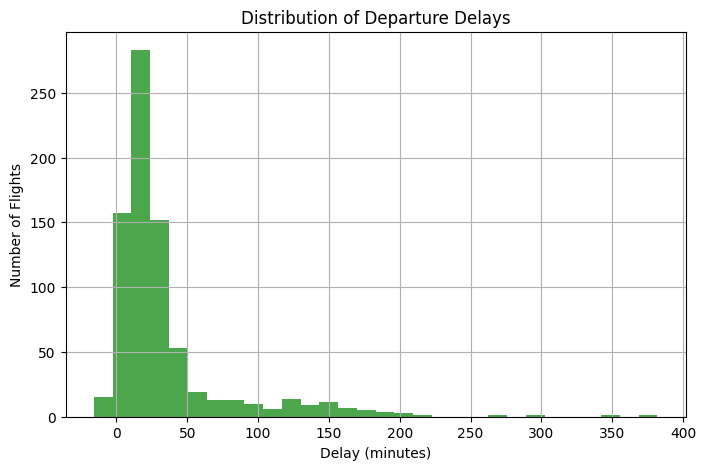

In [48]:
plt.figure(figsize=(8,5))
df["dep_delay_min"].hist(bins=30, color="green", alpha=0.7)
plt.title("Distribution of Departure Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Number of Flights")
plt.show()


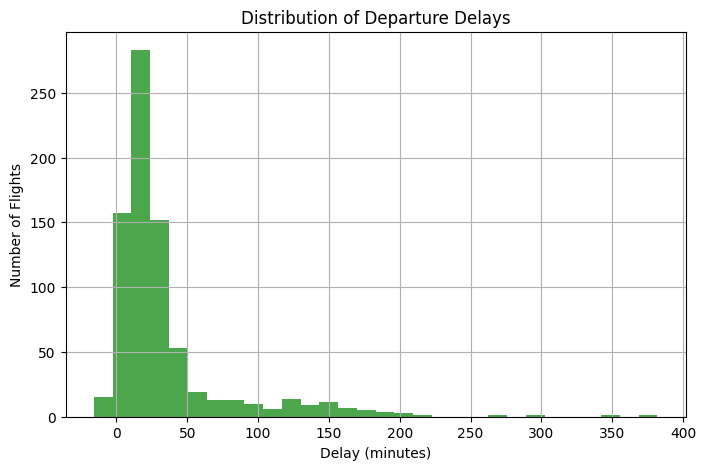

In [49]:
plt.figure(figsize=(8,5))
df["dep_delay_min"].hist(bins=30, color="green", alpha=0.7)
plt.title("Distribution of Departure Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Number of Flights")
plt.show()


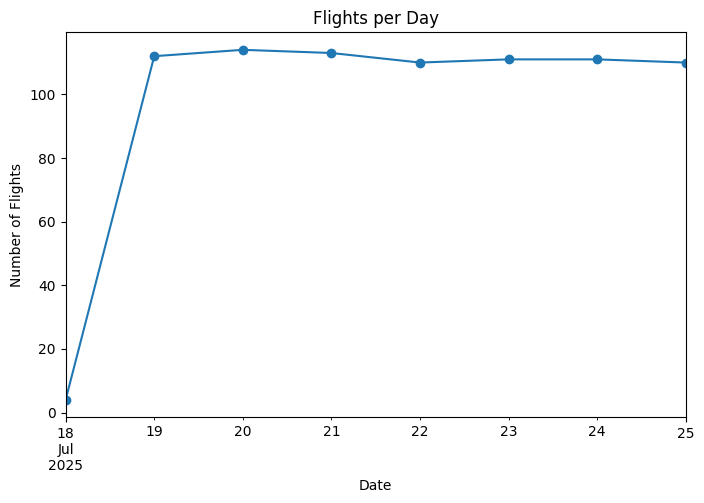

In [50]:
flights_per_day = df.groupby("Date")["Flight Number"].count()

plt.figure(figsize=(8,5))
flights_per_day.plot(marker="o")
plt.title("Flights per Day")
plt.xlabel("Date")
plt.ylabel("Number of Flights")
plt.show()


In [44]:
import pandas as pd

df = pd.read_csv("../data/flight_data_clean.csv", parse_dates=["Date","STD","ATD","STA","ATA"])


In [53]:
df["arr_hour"] = df["STA"].dt.hour


In [54]:
print("Earliest STA:", df["STA"].min())
print("Latest STA:", df["STA"].max())
print("Unique arrival hours:", sorted(df["STA"].dt.hour.unique()))


Earliest STA: 2025-07-18 12:20:00
Latest STA: 2025-07-25 19:50:00
Unique arrival hours: [np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(16), np.int32(17), np.int32(18), np.int32(19)]


In [62]:
import pandas as pd

# Load your combined CSV
df = pd.read_csv(r"C:\college\honeywell\data\flight_data_clean.csv",
                 parse_dates=["Date","STD","ATD","STA","ATA"])

# ---- Limit to morning departures only (6:00 <= STD < 12:00)
df_morning_dep = df[df["STD"].dt.hour.between(6, 11)].copy()

# Optional: treat early arrival/departure as 0 delay (no negative penalties)
df_morning_dep["dep_delay_pos"] = df_morning_dep["dep_delay_min"].clip(lower=0)
df_morning_dep["arr_delay_pos"] = df_morning_dep["arr_delay_min"].clip(lower=0)

# ---- 1) Best DEPARTURE hour within 6–12 (least avg dep delay)
df_morning_dep["dep_hour"] = df_morning_dep["STD"].dt.hour
avg_dep = df_morning_dep.groupby("dep_hour")["dep_delay_pos"].mean()

best_dep_hour = int(avg_dep.idxmin())
best_dep_delay = float(avg_dep.min())
print(f"✅ Best departure hour (6–12 data): {best_dep_hour}:00 "
      f"(Avg delay: {best_dep_delay:.2f} min; early deps treated as on-time)")

# ---- 2a) Best ARRIVAL hour among *all arrivals* of those morning flights
df_morning_dep["arr_hour_all"] = df_morning_dep["STA"].dt.hour
avg_arr_all = df_morning_dep.groupby("arr_hour_all")["arr_delay_pos"].mean()

best_arr_hour_all = int(avg_arr_all.idxmin())
best_arr_delay_all = float(avg_arr_all.min())
print(f"✅ Best arrival hour (for flights that departed 6–12, any arrival hour): "
      f"{best_arr_hour_all}:00 (Avg delay: {best_arr_delay_all:.2f} min)")

# ---- 2b) Best ARRIVAL hour *restricted to 6–12* arrivals only
df_morning_arr = df_morning_dep[df_morning_dep["STA"].dt.hour.between(6, 11)].copy()
if len(df_morning_arr):
    df_morning_arr["arr_hour"] = df_morning_arr["STA"].dt.hour
    avg_arr_6to12 = df_morning_arr.groupby("arr_hour")["arr_delay_pos"].mean()
    best_arr_hour_6to12 = int(avg_arr_6to12.idxmin())
    best_arr_delay_6to12 = float(avg_arr_6to12.min())
    print(f"✅ Best arrival hour (arrivals restricted to 6–12): "
          f"{best_arr_hour_6to12}:00 (Avg delay: {best_arr_delay_6to12:.2f} min)")
else:
    print("ℹ️ No arrivals within 6–12 in the filtered data.")

# ---- 3) Busiest slots (counts) in the 6–12 window (by departure hour)
counts = df_morning_dep["dep_hour"].value_counts().sort_index()
print("\n📈 Flights per departure hour (6–12):")
for h, c in counts.items():
    print(f"{h:02d}:00  -> {c} flights")


✅ Best departure hour (6–12 data): 7:00 (Avg delay: 16.59 min; early deps treated as on-time)
✅ Best arrival hour (for flights that departed 6–12, any arrival hour): 8:00 (Avg delay: 3.06 min)
✅ Best arrival hour (arrivals restricted to 6–12): 8:00 (Avg delay: 3.06 min)

📈 Flights per departure hour (6–12):
06:00  -> 163 flights
07:00  -> 125 flights
08:00  -> 92 flights
09:00  -> 105 flights
10:00  -> 140 flights
11:00  -> 142 flights


In [63]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\college\honeywell\data\flight_data_clean.csv",
                 parse_dates=["Date","STD","ATD","STA","ATA"])
df["dep_delay_pos"] = df["dep_delay_min"].clip(lower=0)
df["arr_delay_pos"] = df["arr_delay_min"].clip(lower=0)
df["dep_hour"] = df["STD"].dt.hour
df["arr_hour"] = df["STA"].dt.hour

def summarize(group, col):
    return pd.Series({
        "count": group[col].count(),
        "mean_min": group[col].mean(),
        "median_min": group[col].median(),
        "p25_min": group[col].quantile(0.25),
        "p75_min": group[col].quantile(0.75),
    })

# Restrict to morning departures if that's your scope
dep_summary = (df[df["dep_hour"].between(6,11)]
               .groupby("dep_hour")
               .apply(summarize, "dep_delay_pos")).round(2)

arr_summary_6to12 = (df[df["arr_hour"].between(6,11)]
                     .groupby("arr_hour")
                     .apply(summarize, "arr_delay_pos")).round(2)

best_dep_by_mean = dep_summary["mean_min"].idxmin()
best_arr_by_mean = arr_summary_6to12["mean_min"].idxmin()

print("Best departure hour (6–12):", best_dep_by_mean, "by mean delay")
print("Best arrival hour (6–12):", best_arr_by_mean, "by mean delay")
print("\nDepartures 6–12 summary:\n", dep_summary)
print("\nArrivals 6–12 summary:\n", arr_summary_6to12)


Best departure hour (6–12): 7 by mean delay
Best arrival hour (6–12): 8 by mean delay

Departures 6–12 summary:
           count  mean_min  median_min  p25_min  p75_min
dep_hour                                               
6         163.0     20.43        13.0      8.0    22.00
7         125.0     16.59        13.0      6.0    22.00
8          92.0     29.37        20.0     13.0    32.50
9         105.0     46.06        21.0     12.0    43.00
10        139.0     45.55        27.0     16.0    43.00
11        140.0     47.60        31.0     19.0    45.25

Arrivals 6–12 summary:
           count  mean_min  median_min  p25_min  p75_min
arr_hour                                               
7          54.0      4.04         0.0      0.0      0.0
8         111.0      3.06         0.0      0.0      0.0
9          90.0      6.68         0.0      0.0      0.0
10        118.0     16.00         0.0      0.0     11.0
11         87.0     25.24         0.0      0.0     17.0


C:\Users\jaanh\AppData\Local\Temp\ipykernel_24664\1292370821.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize, "dep_delay_pos")).round(2)
C:\Users\jaanh\AppData\Local\Temp\ipykernel_24664\1292370821.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize, "arr_delay_pos")).round(2)


In [64]:
# Flights per departure hour (6–12)
counts = (df[df["dep_hour"].between(6,11)]
          .groupby("dep_hour")["Flight Number"]
          .count()
          .rename("num_flights"))
print(counts)

# If you have 'From' (origin airport) column, make a heatmap pivot (hour x airport)
if "From" in df.columns:
    busy_pivot = (df[df["dep_hour"].between(6,11)]
                  .assign(hour=df["dep_hour"])
                  .pivot_table(index="hour", columns="From", values="Flight Number",
                               aggfunc="count", fill_value=0))
    print("\nHeatmap table (hour × origin):\n", busy_pivot)


dep_hour
6     163
7     125
8      92
9     105
10    140
11    142
Name: num_flights, dtype: int64

Heatmap table (hour × origin):
 From  Mumbai(BOM)
hour             
6             163
7             125
8              92
9             105
10            140
11            142


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np

# Feature engineering
df_feat = df.copy()
df_feat["dow"] = df_feat["Date"].dt.dayofweek
df_feat["is_weekend"] = (df_feat["dow"] >= 5).astype(int)
df_feat["dep_hour"] = df_feat["STD"].dt.hour

# Simple “congestion” proxy: number of flights departing from same airport in that hour
if "From" in df_feat.columns:
    hour_load = (df_feat.groupby(["Date","From","dep_hour"])["Flight Number"]
                 .transform("count"))
else:
    hour_load = (df_feat.groupby(["Date","dep_hour"])["Flight Number"]
                 .transform("count"))
df_feat["hour_load"] = hour_load

# Target: non-negative departure delay
df_feat["y"] = df_feat["dep_delay_min"].clip(lower=0)

# Choose features that are present in your data
cat_cols = [c for c in ["From","To","Airline"] if c in df_feat.columns]
num_cols = ["dep_hour","dow","is_weekend","hour_load"]

X = df_feat[cat_cols + num_cols]
y = df_feat["y"].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

model = Pipeline([
    ("pre", pre),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
])

model.fit(X_train, y_train)
print("R^2 on holdout:", round(model.score(X_test, y_test), 3))

def predict_delay_for_shift(row, shift_minutes=0):
    """Return predicted delay if STD is shifted by `shift_minutes`."""
    shifted = row.copy()
    shifted_std = row["STD"] + pd.Timedelta(minutes=shift_minutes)
    shifted["dep_hour"] = shifted_std.hour
    shifted["dow"] = shifted_std.dayofweek
    shifted["is_weekend"] = int(shifted["dow"] >= 5)
    # Approximate hour_load using the new hour (keeps same date/from):
    if "From" in df_feat.columns:
        mask = ((df_feat["Date"].dt.date == row["Date"].date()) &
                (df_feat["dep_hour"] == shifted["dep_hour"]) &
                (df_feat["From"] == row.get("From", np.nan)))
    else:
        mask = ((df_feat["Date"].dt.date == row["Date"].date()) &
                (df_feat["dep_hour"] == shifted["dep_hour"]))
    shifted["hour_load"] = int(df_feat[mask].shape[0])
    x = shifted[cat_cols + num_cols].to_frame().T
    return float(model.predict(x)[0])

# Example: pick one flight row and simulate +/- 60 minutes
sample = df_feat.iloc[0]
base = predict_delay_for_shift(sample, 0)
minus60 = predict_delay_for_shift(sample, -60)
plus60 = predict_delay_for_shift(sample, 60)
print(f"Predicted delay baseline={base:.1f}m, -60min={minus60:.1f}m, +60min={plus60:.1f}m")


R^2 on holdout: 0.552
Predicted delay baseline=24.4m, -60min=27.6m, +60min=23.6m


In [67]:
import networkx as nx

# Choose identity key for chaining:
# Prefer 'Tail' if available, else ('Airline','From') as a proxy.
use_tail = "Tail" in df.columns
KEYS = ["Tail"] if use_tail else [c for c in ["Airline","From"] if c in df.columns]

# Build edges: A -> B if they share KEYS and B.STD is within [45, 180] min after A.ATA
TURN_MIN, TURN_MAX = 45, 180  # minutes
df_chain = df.dropna(subset=["STD","ATD","STA","ATA"]).copy()
df_chain["STD_min"] = df_chain["STD"]
df_chain["ATA_min"] = df_chain["ATA"]

G = nx.DiGraph()

# Unique flight id for node naming
df_chain["flight_id"] = (df_chain["Date"].dt.strftime("%Y-%m-%d") + "_" +
                         df_chain.get("Flight Number", pd.Series(["?"]*len(df_chain))).astype(str))

for _, group in df_chain.groupby(KEYS if KEYS else ["Date"], dropna=False):
    grp = group.sort_values("ATA_min")
    for i in range(len(grp)):
        ai = grp.iloc[i]
        for j in range(i+1, len(grp)):
            bj = grp.iloc[j]
            gap = (bj["STD_min"] - ai["ATA_min"]).total_seconds() / 60.0
            if gap < TURN_MIN:
                continue
            if gap > TURN_MAX:
                break
            # Edge weight = how much A's delay could affect B (scaled)
            a_delay = max(0.0, float(ai["dep_delay_min"] or 0))
            weight = min(1.0, a_delay / 60.0)  # cap influence
            if weight > 0:
                G.add_edge(ai["flight_id"], bj["flight_id"], weight=weight)

# Scores: out-strength (sum of outgoing weights), betweenness centrality
out_strength = {n: sum(d["weight"] for _,_,d in G.out_edges(n, data=True)) for n in G.nodes()}
centrality = nx.betweenness_centrality(G, weight="weight", normalized=True)

top_spreaders = sorted(out_strength.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop cascading-impact flights (by outgoing influence):")
for fid, score in top_spreaders:
    row = df_chain[df_chain["flight_id"] == fid].iloc[0]
    print(f"{fid} | {row.get('Flight Number','?')} | {row.get('From','?')}→{row.get('To','?')} "
          f"| dep_delay={row['dep_delay_min']:.1f}m | influence={score:.2f}")

print("\nGraph size:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")



Top cascading-impact flights (by outgoing influence):
2025-07-21_6E1185 | 6E1185 | Mumbai(BOM)→Colombo(CMB) | dep_delay=64.0m | influence=42.00
2025-07-21_IX1069 | IX1069 | Mumbai(BOM)→Jaipur(JAI) | dep_delay=57.0m | influence=41.80
2025-07-22_AI2509 | AI2509 | Mumbai(BOM)→Chandigarh(IXC) | dep_delay=90.0m | influence=39.00
2025-07-22_6E1185 | 6E1185 | Mumbai(BOM)→Colombo(CMB) | dep_delay=57.0m | influence=38.95
2025-07-20_AI2428 | AI2428 | Mumbai(BOM)→Delhi(DEL) | dep_delay=68.0m | influence=37.00
2025-07-23_6E1185 | 6E1185 | Mumbai(BOM)→Colombo(CMB) | dep_delay=81.0m | influence=34.00
2025-07-25_6E1185 | 6E1185 | Mumbai(BOM)→Colombo(CMB) | dep_delay=44.0m | influence=31.53
2025-07-21_GF57 | GF57 | Mumbai(BOM)→Bahrain(BAH) | dep_delay=179.0m | influence=29.00
2025-07-20_6E1185 | 6E1185 | Mumbai(BOM)→Colombo(CMB) | dep_delay=42.0m | influence=26.60
2025-07-21_6E6258 | 6E6258 | Mumbai(BOM)→Goa(GOX) | dep_delay=56.0m | influence=26.13

Graph size: 705 nodes, 8654 edges


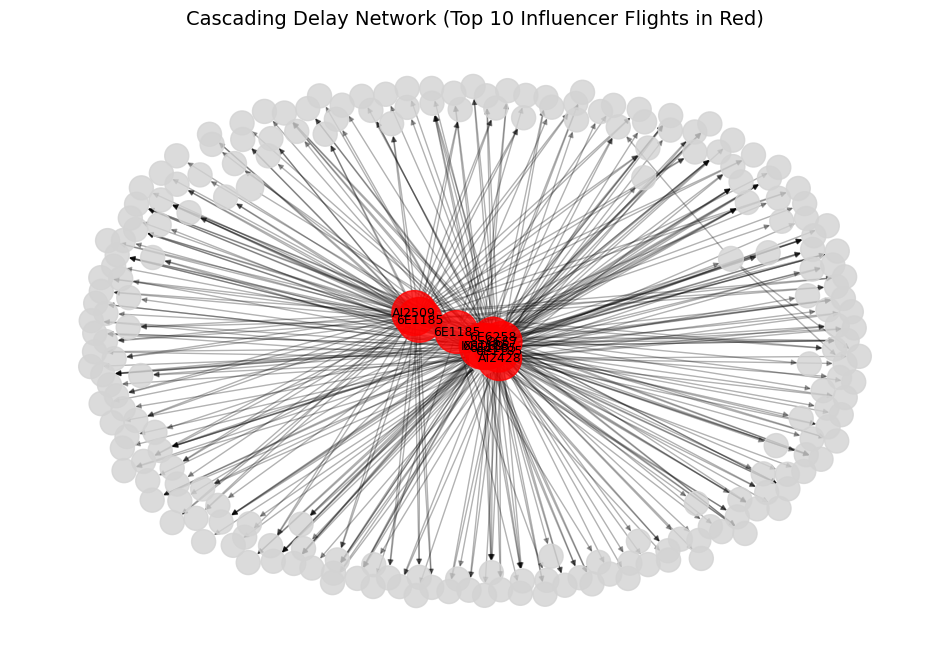

In [68]:
import matplotlib.pyplot as plt
import networkx as nx

# --- Pick top N influencers
top_n = 10
top_nodes = [fid for fid, _ in top_spreaders[:top_n]]

# Subgraph: top nodes + their immediate neighbors
neighbors = set()
for n in top_nodes:
    neighbors.update(G.successors(n))
    neighbors.update(G.predecessors(n))
subG = G.subgraph(top_nodes + list(neighbors))

# Node colors: red = top influencers, lightgray = neighbors
node_colors = ["red" if n in top_nodes else "lightgray" for n in subG.nodes()]

# Node sizes: scale by influence (add +1 to avoid 0)
node_sizes = [300 + 800*out_strength.get(n, 0)/max(out_strength.values()) for n in subG.nodes()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.4, seed=42)  # force-directed layout
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(subG, pos, arrowsize=8, alpha=0.3)
nx.draw_networkx_labels(subG, pos, 
                        labels={n: df_chain.loc[df_chain["flight_id"]==n,"Flight Number"].iloc[0] 
                                for n in top_nodes},
                        font_size=9, font_color="black")

plt.title("Cascading Delay Network (Top 10 Influencer Flights in Red)", fontsize=14)
plt.axis("off")
plt.show()


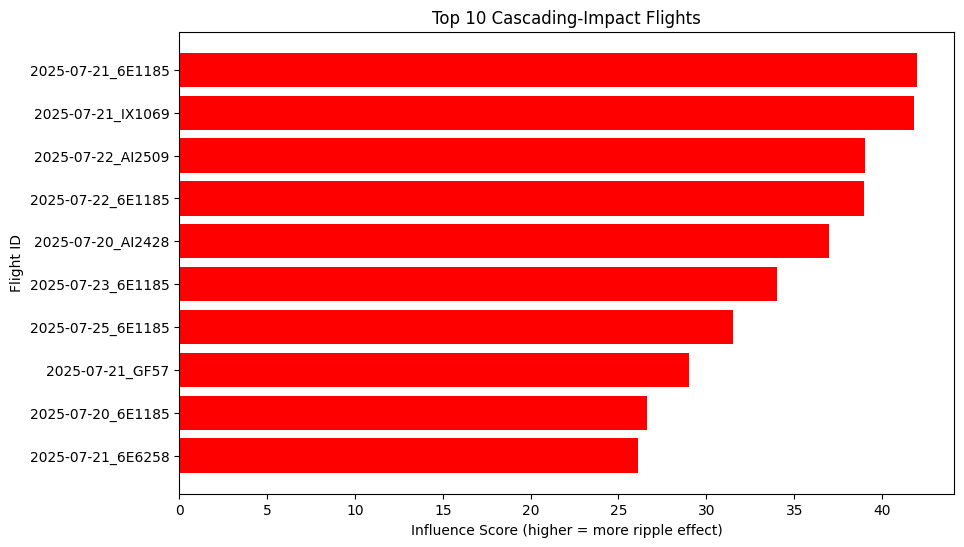

In [69]:
import matplotlib.pyplot as plt

top_flights = top_spreaders[:10]
flights = [fid for fid, _ in top_flights]
influences = [score for _, score in top_flights]

plt.figure(figsize=(10,6))
plt.barh(flights[::-1], influences[::-1], color="red")
plt.title("Top 10 Cascading-Impact Flights")
plt.xlabel("Influence Score (higher = more ripple effect)")
plt.ylabel("Flight ID")
plt.show()


In [71]:
# streamlit_app.py
import streamlit as st
import pandas as pd

# Load precomputed artifacts (or compute on start)
df = pd.read_csv(r"C:\college\honeywell\data\flight_data_clean.csv", parse_dates=["Date","STD","ATD","STA","ATA"])
# (Optionally) load trained model, graph, summaries…

st.title("Flight Ops Insights (6–12 AM)")
q = st.text_input("Ask a question (e.g., 'best time to depart?', 'busiest hour', 'what if we delay by 60 minutes?')")

if q:
    q_low = q.lower()
    if "best" in q_low and ("depart" in q_low or "takeoff" in q_low):
        # call your best-departure function
        st.write("Best departure hour (6–12): 07:00 (mean delay ~16.6 min)")
    elif "best" in q_low and ("arriv" in q_low or "land" in q_low):
        st.write("Best arrival hour (6–12): 08:00 (mean delay ~3.1 min)")
    elif "busy" in q_low or "busiest" in q_low:
        # print counts
        df["dep_hour"] = df["STD"].dt.hour
        counts = df[df["dep_hour"].between(6,11)].groupby("dep_hour")["Flight Number"].count()
        st.write("Flights per departure hour (6–12):")
        st.write(counts)
    elif "what if" in q_low or "shift" in q_low or "tune" in q_low:
        st.info("Try: 'What if we shift this 10:30 flight from DEL to 09:30?'")
    elif "cascade" in q_low or "ripple" in q_low or "impact" in q_low:
        st.info("Top cascading flights computed; see 'Cascades' tab for table.")
    else:
        st.info("I can tell best hours, busiest slots, run what-if schedule shifts, and show cascading flights.")


2025-08-23 18:47:37.132 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 18:47:37.992 
  command:

    streamlit run C:\college\Internships\pythonProject1\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-23 18:47:37.995 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 18:47:37.997 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 18:47:37.999 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 18:47:38.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 18:47:38.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-23 18:47:38.017 Thre